In [1]:
import django, sys, os
sys.path.append('/home/max/software/django-tmv/tmv_mcc-apsis/BasicBrowser')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from scoping.models import *
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from itertools import product, combinations
from utils.text import *
from pycountry_convert import  country_alpha2_to_continent_code, country_alpha3_to_country_alpha2
from cities.models import *
import matplotlib.pyplot as plt
import pandas as pd
import datetime
now = datetime.datetime.now().strftime("%Y-%m-%d %H:%M")
import seaborn as sns
import scipy.stats as st
from django.db.models.functions import Concat
from django.db.models import CharField, Value as V

from django.utils import timezone as tz

django.db.connection.close()


In [2]:
p = Project.objects.get(pk=178)

dos = DocOwnership.objects.filter(query__project=p, relevant__gt=0)
dos.count()

2921

In [3]:
df = pd.DataFrame.from_dict(dos.order_by('user','finish').values(
    'id','doc_id','doc__title','tag__title','tag__id','user__username',
    'date','finish','start','relevant'
))

df['start'] = df['finish'].shift(1)
df['time'] = df['finish'] - df['start']
df['time'] = df['time'].astype('timedelta64[s]')
df.loc[df['relevant']==2,'relevant'] = 0
df.loc[df['relevant']==3,'relevant'] = np.NaN
maxtime = 600
maxtime = 2400
df.loc[df['time']>maxtime,'time'] = np.NaN
df.loc[df['time']<0,'time'] = np.NaN
df['tag'] = df['tag__id'].astype(str) + " - " + df['tag__title']
df.tail()


,id,doc_id,doc__title,tag__title,tag__id,user__username,date,finish,start,relevant,time,tag
2916,1233019,1449050,Hydrohalite in cold sea ice: Laboratory observ...,"Food, conflict, migration - prediction>0.3 3",5385,nicole.vanmaanen@climateanalytics.org,2020-04-30 10:06:33.789905+00:00,2020-05-07 16:02:51.072356+00:00,2020-05-07 15:59:16.845255+00:00,0.0,214.0,"5385 - Food, conflict, migration - prediction>..."
2917,1233021,1465136,Recent Walker circulation strengthening and Pa...,"Food, conflict, migration - prediction>0.3 3",5385,nicole.vanmaanen@climateanalytics.org,2020-04-30 10:06:34.168948+00:00,2020-05-07 16:07:31.427246+00:00,2020-05-07 16:02:51.072356+00:00,0.0,280.0,"5385 - Food, conflict, migration - prediction>..."
2918,1233023,1533260,"A recent greening of the Sahel - Trends, patte...","Food, conflict, migration - prediction>0.3 3",5385,nicole.vanmaanen@climateanalytics.org,2020-04-30 10:06:34.643492+00:00,2020-05-07 16:09:39.212704+00:00,2020-05-07 16:07:31.427246+00:00,1.0,127.0,"5385 - Food, conflict, migration - prediction>..."
2919,1216867,787082,The effects of elevated temperature and dissol...,predicted relevant sample 2020-03-25 09:21,5182,jean-david.coulibaly@climateanalytics.org,2020-03-30 20:35:26.211062+00:00,2020-04-03 09:44:08.460978+00:00,2020-05-07 16:09:39.212704+00:00,1.0,NaN,5182 - predicted relevant sample 2020-03-25 09:21
2920,1216868,1271812,Avian influenza virus ecology and evolution th...,predicted relevant sample 2020-03-25 09:21,5182,jean-david.coulibaly@climateanalytics.org,2020-03-30 20:35:26.225659+00:00,2020-04-03 09:55:49.565760+00:00,2020-04-03 09:44:08.460978+00:00,1.0,701.0,5182 - predicted relevant sample 2020-03-25 09:21


No handles with labels found to put in legend.


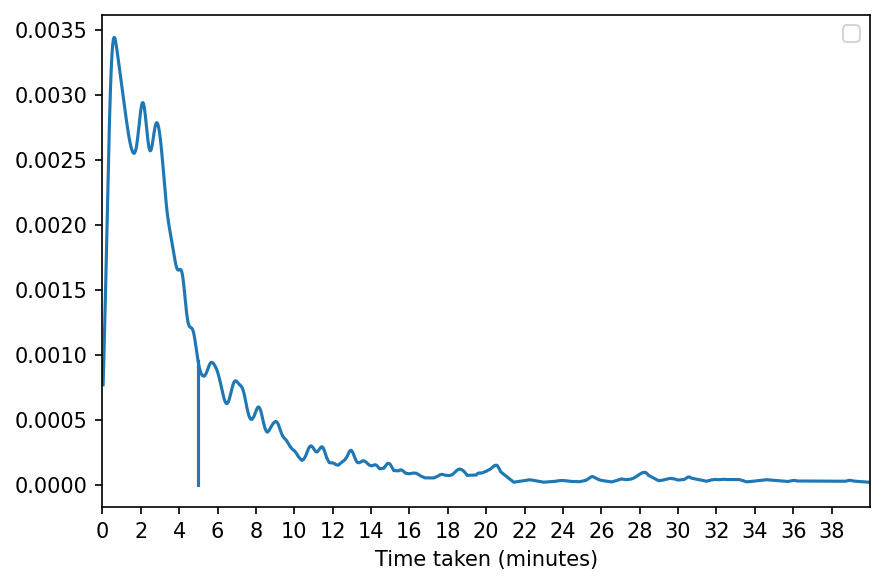

In [4]:
fig, ax = plt.subplots(dpi=150)

ticksize = (60*2)
nticks = maxtime//ticksize
minticks, minticklabels = zip(*[(i*ticksize,i*2) for i in range(nticks)])



#for i, (name, group) in enumerate(df.groupby('tag__title')):
group = df.query('tag__id>4764')
i = 0
values = group.sort_values('time').loc[pd.notna(group['time']),'time']
kernel = st.gaussian_kde(values, bw_method=0.03)
ax.plot(
    kernel.dataset.ravel(),
    kernel.pdf(kernel.dataset),
    #label=f"{name} (| mean)",
    color=f"C{i}"
)
mean = np.mean(values)
ax.plot(
    [mean,mean],
    [0,kernel.pdf(mean)],
    color=f"C{i}"
)

ax.set_xticks(minticks)
ax.set_xticklabels(minticklabels)
ax.set_xlim(0,maxtime)

ax.set_xlabel('Time taken (minutes)')

ax.legend()

fig.tight_layout()

plt.savefig(f'../plots/progress/time_taken_kde.pdf')

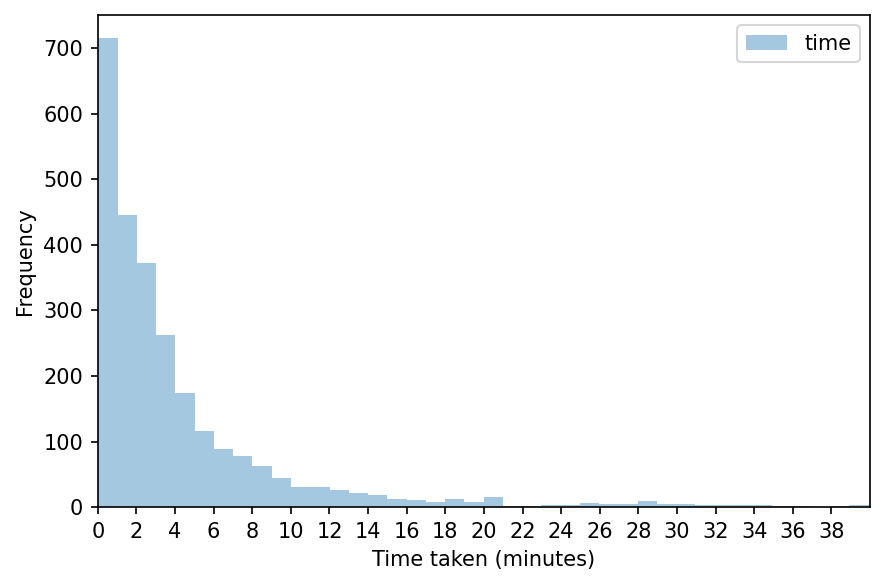

In [5]:
fig, ax = plt.subplots(dpi=150)

ticksize = (60*2)
nticks = maxtime//ticksize
minticks, minticklabels = zip(*[(i*ticksize,i*2) for i in range(nticks)])


#for name, group in df.groupby('tag__title'):
#    group['time'].plot.hist(bins=nticks*2, ax = ax, label=name,alpha=0.4)


df['time'].plot.hist(bins=nticks*2, ax = ax, alpha=0.4)

ax.set_xticks(minticks)
ax.set_xticklabels(minticklabels)
ax.set_xlim(0,maxtime)

ax.set_xlabel('Time taken (minutes)')

ax.legend()

fig.tight_layout()

plt.savefig(f'../plots/progress/time_taken_hist.pdf')

4680 - random sample 1 (500, 12)
4764 - predicted relevant sample 2020-02-18 13:14 (180, 12)
5178 - predicted relevant sample 2020-03-24 09:36 (68, 12)
5182 - predicted relevant sample 2020-03-25 09:21 (278, 12)
5191 - predicted Terrestrial ES sample 2020-03-25 15:17 (60, 12)
5192 - predicted Mountains, snow and ice sample 2020-03-25 15:17 (30, 12)
5193 - predicted Human and managed sample 2020-03-25 15:17 (40, 12)
5194 - predicted Oceans and Coasts sample 2020-03-25 15:17 (40, 12)
5195 - predicted Rivers lakes and moisture sample 2020-03-25 15:17 (60, 12)
5196 - predicted climate system sample 2020-03-25 15:17 (60, 12)
5243 - predicted relevant sample 2020-03-31 08:21 (20, 12)
5247 - predicted relevant sample 2020-04-01 08:29 (105, 12)
5251 - predicted 12 - Physical systems sample 2020-04-01 10:09:10.283298 (150, 12)
5252 - predicted 12 - Rivers, lakes, and soil moisture sample 2020-04-01 10:09:10.283298 (150, 12)
5253 - predicted 12 - Coastal and marine Ecosystems sample 2020-04-01 1

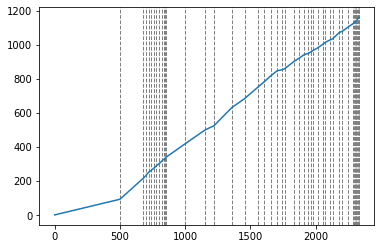

In [6]:
df['tag'] = df['tag__id'].astype(str) + " - " + df['tag__title']
fig, ax = plt.subplots()
xs = [0]
ys = [0]
x=0
y=0
for name, group in df.groupby('tag'):
    print(name, group.shape)
    y += len(group.query('relevant==1')['doc_id'].unique())
    x += len(group['doc_id'].unique())
    xs.append(x)
    ys.append(y)
    ax.axvline(
        x,
        color="grey",
        lw=1,
        linestyle="--"
    )
ax.plot(xs,ys)

In [7]:
df.head()

,id,doc_id,doc__title,tag__title,tag__id,user__username,date,finish,start,relevant,time,tag
0,815641,1402069,Respiratory syncytial virus infection in tropi...,random sample 1,4680,galm,2020-01-07 16:39:56.655828+00:00,2020-01-08 09:25:31.587161+00:00,NaT,0.0,NaN,4680 - random sample 1
1,815642,198072,Conservation of threatened relict trees throug...,random sample 1,4680,galm,2020-01-07 16:39:56.656706+00:00,2020-01-08 10:10:49.260548+00:00,2020-01-08 09:25:31.587161+00:00,0.0,NaN,4680 - random sample 1
2,815643,2317280,Climate Change on Newfoundland and Labrador Sh...,random sample 1,4680,galm,2020-01-07 16:39:56.656833+00:00,2020-01-08 10:23:18.725312+00:00,2020-01-08 10:10:49.260548+00:00,1.0,749.0,4680 - random sample 1
3,815644,140076,Influence of relief on permanent preservation ...,random sample 1,4680,galm,2020-01-07 16:39:56.656996+00:00,2020-01-08 10:40:20.522245+00:00,2020-01-08 10:23:18.725312+00:00,0.0,1021.0,4680 - random sample 1
4,815645,693857,"If Stationarity is Dead, What Do We Do Now?",random sample 1,4680,galm,2020-01-07 16:39:56.657119+00:00,2020-01-08 10:40:59.646480+00:00,2020-01-08 10:40:20.522245+00:00,0.0,39.0,4680 - random sample 1


In [8]:
print(df.shape)
gdf = df.groupby('doc_id').agg(lambda x: st.mode(x)[0][0]).reset_index()
gdf = gdf.sort_values('tag__id').reset_index(drop=True)
print(gdf.shape)
gdf.tail()



(2921, 12)
(2322, 12)


,doc_id,id,doc__title,tag__title,tag__id,user__username,date,finish,start,relevant,time,tag
2317,244995,1625243,Measuring the economic impact of climate chang...,economic,5822,galm,2020-10-07 10:36:16.714965+00:00,2020-10-07 11:11:19.773276+00:00,2020-10-07 10:42:19.824179+00:00,1.0,1739.0,5822 - economic
2318,127845,1625261,Migration and reclamation in Northeast China i...,migration - extra 5,5823,galm,2020-10-07 13:18:19.011354+00:00,2020-10-07 13:20:21.227163+00:00,2020-10-07 12:23:27.528812+00:00,1.0,NaN,5823 - migration - extra 5
2319,693855,1625266,Contrasted Views on Environmental Change and M...,migration - extra 5,5823,galm,2020-10-07 13:18:20.015276+00:00,2020-10-07 13:24:10.157128+00:00,2020-10-07 13:20:21.227163+00:00,1.0,228.0,5823 - migration - extra 5
2320,484817,1625299,"Climatic change, wars and dynastic cycles in C...",conflict,5824,galm,2020-10-07 13:41:36.406867+00:00,2020-10-07 13:46:26.063290+00:00,2020-10-07 13:24:10.157128+00:00,1.0,1335.0,5824 - conflict
2321,1520101,1625325,Estimating the Effects of Climate Shocks on Co...,war,5825,galm,2020-10-07 13:42:50.244735+00:00,2020-10-07 13:58:22.788190+00:00,2020-10-07 13:46:26.063290+00:00,1.0,716.0,5825 - war


(2322, 16) 1125


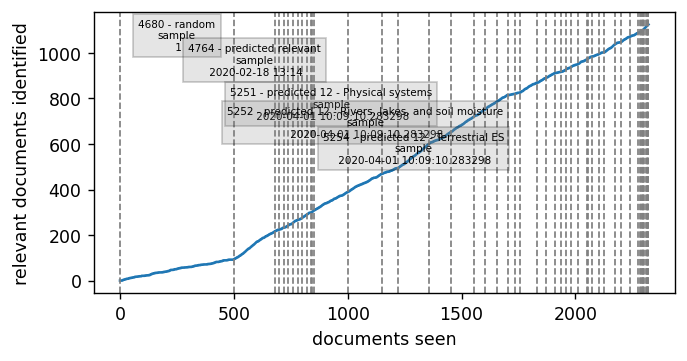

In [9]:
gdf['is_relevant'] = 0
gdf.loc[gdf['relevant']==1,'is_relevant'] = 1
gdf['cum_relevant'] = gdf['is_relevant'].cumsum()
gdf['seen'] = 1
gdf['cum_seen'] = gdf['seen'].cumsum()

print(gdf.shape, gdf['cum_relevant'].max())

fig, ax = plt.subplots(dpi=125)

ax.plot(gdf['cum_relevant'])

ax.set_xlabel('documents seen')
ax.set_ylabel('relevant documents identified')

for name, group in gdf.groupby('tag'):
    ax.axvline(
        group.index[0],
        color="grey",
        lw=1,
        linestyle="--"
    )
    if group.shape[0] > 100:
        ax.text(
            np.mean(group.index), 
            gdf['cum_relevant'].max()-group['cum_relevant'].mean(), 
            name.replace(' sample','\nsample\n'),
            ha="center", va="center",
            fontsize=6,
            bbox={'facecolor': 'grey', 'alpha': 0.2, 'pad': 3}
        )

ax.set_aspect('equal')

plt.savefig(f'../plots/progress/reldocs_docs.pdf')
plt.show()

(1642, 16) 1125


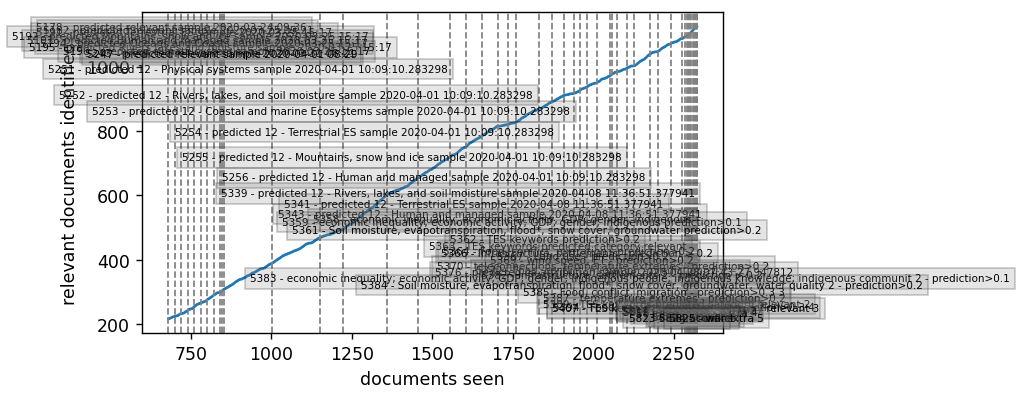

In [10]:
fig, ax = plt.subplots(dpi=125)

pdf = gdf.query('tag__id>4764')

print(pdf.shape, pdf['cum_relevant'].max())

ax.plot(pdf['cum_relevant'])

ax.set_xlabel('documents seen')
ax.set_ylabel('relevant documents identified')

for name, group in pdf.groupby('tag'):
    ax.axvline(
        group.index[0],
        color="grey",
        lw=1,
        linestyle="--"
    )
    try:
        l = name.split('predicted')[1].split('sample')[0]
    except:
        l = name
    ax.text(
        np.mean(group.index), 
        gdf['cum_relevant'].max()-group['cum_relevant'].mean()+pdf['cum_relevant'].min(), 
        name,
        ha="center", va="center",
        fontsize=6,
        bbox={'facecolor': 'grey', 'alpha': 0.2, 'pad': 3}
    )

ax.set_aspect('equal')

plt.savefig(f'../plots/progress/reldocs_docs_recent.pdf')
plt.show()

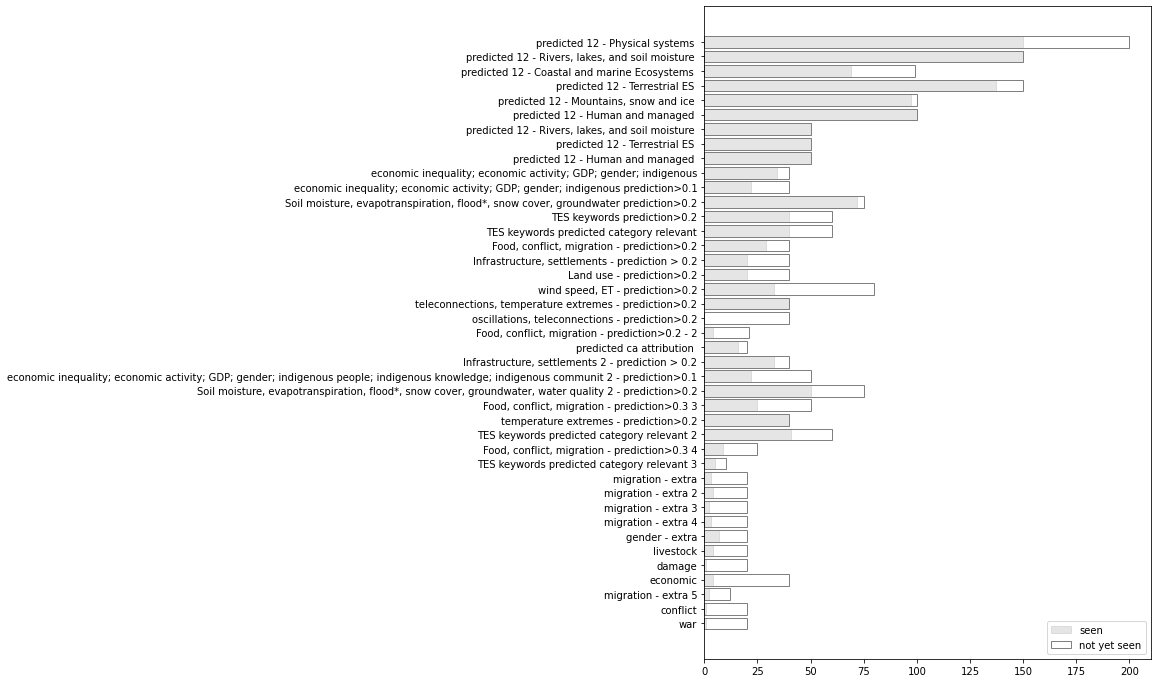

In [11]:
fig, ax = plt.subplots(figsize=(8,12))

ticks = []
for i, tag in enumerate(Tag.objects.filter(query__id__in=[8145,8272],id__gt=5247).order_by('-id')):
    n = tag.docownership_set.count()
    r = tag.docownership_set.filter(relevant__gt=0).count()
    ax.barh(i,n,color="none",edgecolor="grey",linewidth=1)
    ax.barh(i,r,color="grey",alpha=0.2,edgecolor="grey",linewidth=1)
    #try:
    #    ticks.append(tag.title.split('- ')[1].split('sample')[0])
    #except:
    #    ticks.append(tag.title)
    ticks.append(tag.title.split('sample')[0])
    
ax.barh(0,0,color="grey",alpha=0.2,edgecolor="grey",linewidth=1,label="seen")
ax.barh(0,0,color="none",edgecolor="grey",linewidth=1, label="not yet seen")

ax.legend()
    
ax.set_yticks(range(len(ticks)))
ax.set_yticklabels(ticks)

plt.show()

11.0 0
9.0 1
10.5 2
11.5 3
14.0 4
10.5 5
14 6
11.0 7
2 8


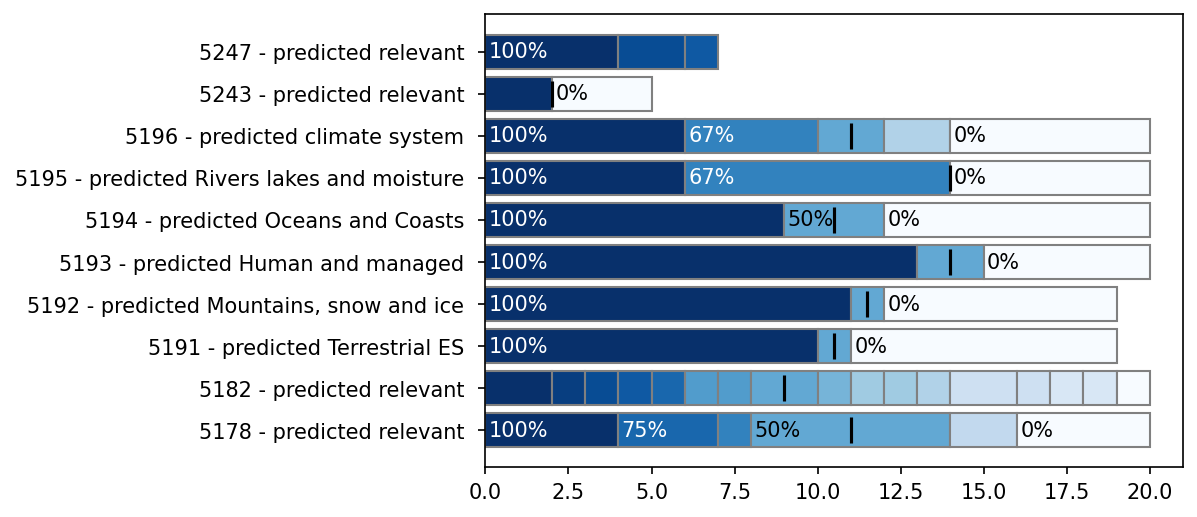

In [12]:
fig, ax = plt.subplots(dpi=150)
from matplotlib import cm
cmap = cm.get_cmap('Blues', 20)
ticklabels=[]

for i, (name, group) in enumerate(df.query('tag__id>4764').query('tag__id<5251').groupby('tag')):
    half = None
    ticklabels.append(name.split('sample')[0])
    gg = gg = group.groupby('doc_id').aggregate({
        "relevant": ['count','sum'] 
    })
    gg.columns = ['count', 'sum']
    gg = gg.reset_index()
    gg['r'] = gg['sum']/gg['count']
    grouped = gg.groupby('r')['r'].count().sort_index(ascending=False)
    l = 0
    for name, s in grouped.iteritems():
        ax.barh(
            i,s,left=l,color=cmap(name),
            linewidth=1,
            edgecolor="grey"
        )
        if name > 0.5:
            c = "white"
        else:
            c = "black"
        if s >2:
            ax.text(l+0.1,i,f"{name:.0%}",color=c,va="center",ha="left")
        if not half:
            if name==0.5:
                half=l+s*0.5
            elif name<0.5:
                half=l
            if half:
                ax.scatter(half,i,zorder=5,marker="|",color="black",s=150)
                print(half,i)
        l+=s
        

ax.set_yticks(list(range(len(ticklabels))))   
ax.set_yticklabels(ticklabels)
plt.show()

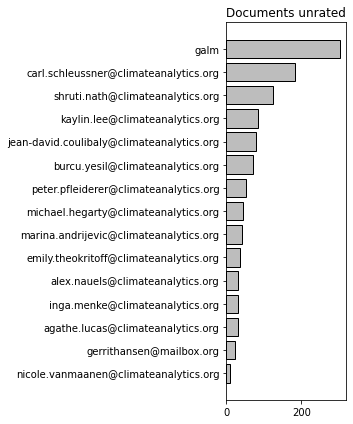

In [13]:
users = DocOwnership.objects.filter(
    query__id__in=[8145,7368,8272],
    relevant=0
).values('user__username').annotate(
    n = Count('pk')
).order_by('-n')[:15]

udf = pd.DataFrame.from_dict(list(users)).sort_values('n').reset_index(drop=True)

fig, ax = plt.subplots(figsize=(5,6))

ax.barh(udf.index,udf['n'],color="#bdbdbd",edgecolor="black")
ax.set_yticks(udf.index)
ax.set_yticklabels(udf['user__username'])

ax.set_title('Documents unrated')

plt.tight_layout()

plt.show()

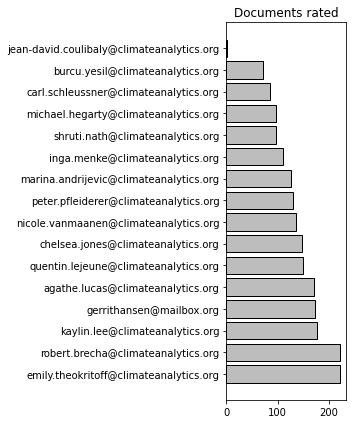

In [14]:
django.db.connection.close()
start = tz.now() - datetime.timedelta(days=1)
users = DocOwnership.objects.filter(
    query__id__in=[8145,7368,8272],
    #finish__gt=start,
    #tag__id__gt=5250,
    user__pk__gt=1,
    relevant__gt=0
).values('user__username').annotate(
    n = Count('pk')
).order_by('-n')[:20]

udf = pd.DataFrame.from_dict(list(users))#.sort_values('n').reset_index(drop=True)

fig, ax = plt.subplots(figsize=(5,6))

ax.barh(udf.index,udf['n'],color="#bdbdbd",edgecolor="black")
ax.set_yticks(udf.index)
ax.set_yticklabels(udf['user__username'])

ax.set_title('Documents rated')

plt.tight_layout()

plt.savefig('user_ratings.png')

plt.show()

In [15]:
udf.tail()

,user__username,n
11,shruti.nath@climateanalytics.org,97
12,michael.hegarty@climateanalytics.org,97
13,carl.schleussner@climateanalytics.org,86
14,burcu.yesil@climateanalytics.org,72
15,jean-david.coulibaly@climateanalytics.org,2


In [16]:
django.db.connection.close()
DocOwnership.objects.filter(
    query__id__in=[8145,7368,8272],
    tag__id__gt=5177,
    relevant__gt=0,
    user__id__gt=1
).count()

2120

In [17]:
len(set(DocOwnership.objects.filter(
    query__id__in=[8145,7368,8272],
    tag__id__gt=5177,
    relevant__gt=0,
    user__id__gt=1
).values_list('doc__pk',flat=True)))

1572

In [18]:
np.array(pdf['finish'])

array([Timestamp('2020-03-24 13:36:24.395864+0000', tz='UTC'),
       Timestamp('2020-03-24 13:55:45.977370+0000', tz='UTC'),
       Timestamp('2020-03-24 12:29:01.484855+0000', tz='UTC'), ...,
       Timestamp('2020-10-07 13:24:10.157128+0000', tz='UTC'),
       Timestamp('2020-10-07 13:46:26.063290+0000', tz='UTC'),
       Timestamp('2020-10-07 13:58:22.788190+0000', tz='UTC')],
      dtype=object)

In [19]:
gdf.sort_values('finish').head()

,doc_id,id,doc__title,tag__title,tag__id,user__username,date,finish,start,relevant,time,tag,is_relevant,cum_relevant,seen,cum_seen
202,1402069,815641,Respiratory syncytial virus infection in tropi...,random sample 1,4680,galm,2020-01-07 16:39:56.655828+00:00,2020-01-08 09:25:31.587161+00:00,NaT,0.0,NaN,4680 - random sample 1,0,39,1,203
479,198072,815642,Conservation of threatened relict trees throug...,random sample 1,4680,galm,2020-01-07 16:39:56.656706+00:00,2020-01-08 10:10:49.260548+00:00,2020-01-08 09:25:31.587161+00:00,0.0,NaN,4680 - random sample 1,0,92,1,480
109,2317280,815643,Climate Change on Newfoundland and Labrador Sh...,random sample 1,4680,galm,2020-01-07 16:39:56.656833+00:00,2020-01-08 10:23:18.725312+00:00,2020-01-08 10:10:49.260548+00:00,1.0,749.0,4680 - random sample 1,1,22,1,110
383,140076,815644,Influence of relief on permanent preservation ...,random sample 1,4680,galm,2020-01-07 16:39:56.656996+00:00,2020-01-08 10:40:20.522245+00:00,2020-01-08 10:23:18.725312+00:00,0.0,1021.0,4680 - random sample 1,0,71,1,384
304,693857,815645,"If Stationarity is Dead, What Do We Do Now?",random sample 1,4680,galm,2020-01-07 16:39:56.657119+00:00,2020-01-08 10:40:59.646480+00:00,2020-01-08 10:40:20.522245+00:00,0.0,39.0,4680 - random sample 1,0,60,1,305


2320    1125
Name: cum_relevant, dtype: int64


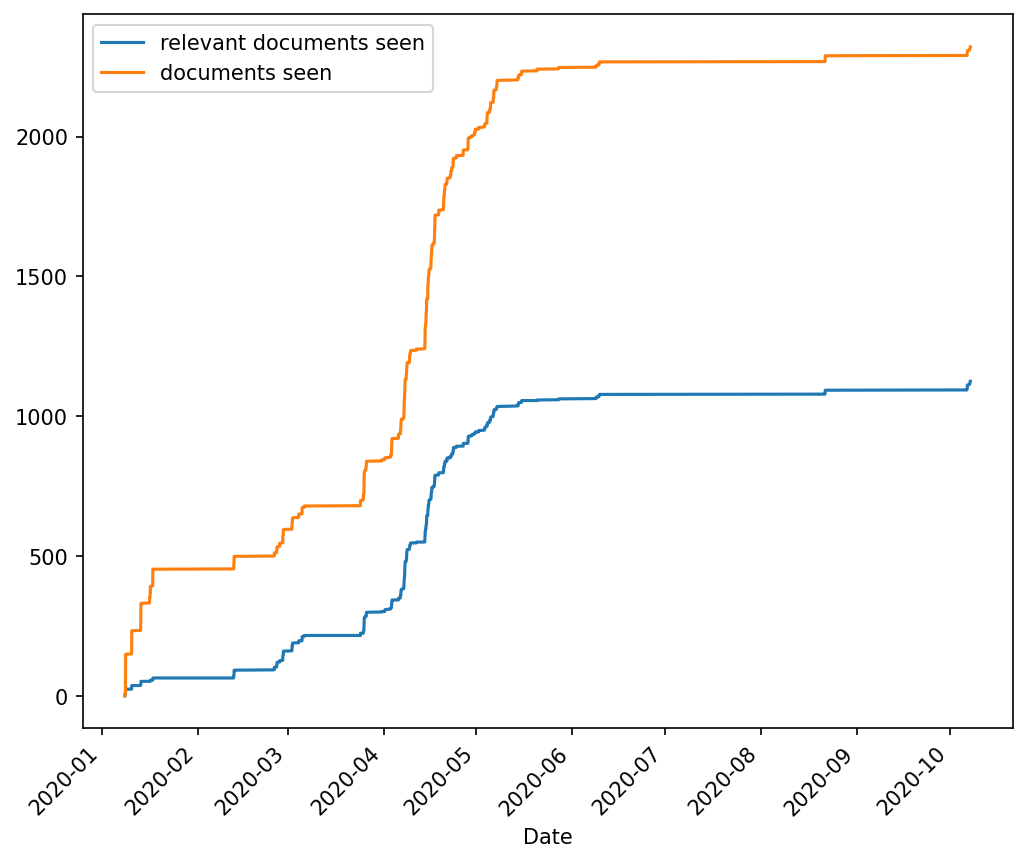

In [23]:
fig, ax = plt.subplots(dpi=150, figsize=(8,7))
pdf = gdf[gdf['start']>tz.make_aware(tz.datetime(2020,1,1,))].sort_values('finish').reset_index(drop=True)
pdf['cum_relevant'] = pdf['is_relevant'].cumsum()
print(pdf['cum_relevant'].tail(1))
pdf['seen'] = 1
pdf['cum_seen'] = pdf['seen'].cumsum().values
plt.plot_date(np.array(pdf['finish']),pdf['cum_relevant'],fmt="-",label="relevant documents seen")
plt.plot_date(np.array(pdf['finish']),pdf['cum_seen'],fmt="-", label="documents seen")
fig.autofmt_xdate(rotation=45)
ax.legend()
ax.set_xlabel('Date')


plt.savefig(f'../plots/progress/docs_time.pdf')
plt.show()

2320    1125
Name: cum_relevant, dtype: int64


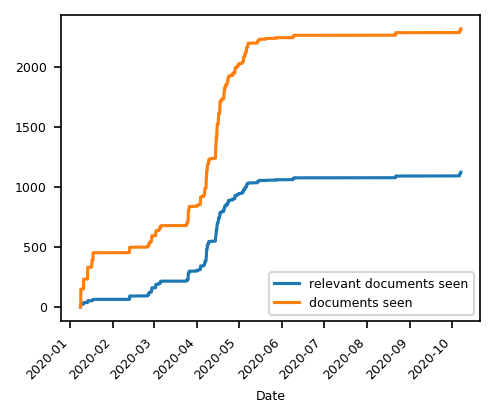

In [31]:
fig, ax = plt.subplots(dpi=150, figsize=(3.6,3))
pdf = gdf[gdf['start']>tz.make_aware(tz.datetime(2020,1,1,))].sort_values('finish').reset_index(drop=True)
pdf['cum_relevant'] = pdf['is_relevant'].cumsum()
print(pdf['cum_relevant'].tail(1))
pdf['seen'] = 1
pdf['cum_seen'] = pdf['seen'].cumsum().values
ax.plot_date(np.array(pdf['finish']),pdf['cum_relevant'],fmt="-",label="relevant documents seen")
ax.plot_date(np.array(pdf['finish']),pdf['cum_seen'],fmt="-", label="documents seen")
fig.autofmt_xdate(rotation=45)
ax.legend(fontsize=6)
ax.set_xlabel('Date', fontsize=6)
ax.tick_params(axis='both', labelsize=6) 


plt.savefig(f'../plots/progress/docs_time.pdf')
plt.savefig(f'../plots/progress/docs_time.png', dpi=150)
plt.show()

In [21]:
DocOwnership.objects.filter(
    query__id__in=[8145,7368,8272],
    tag__id__gt=5177,
    relevant__gt=0,
    user__id__gt=1
).order_by('finish').last().finish

datetime.datetime(2020, 6, 9, 17, 42, 17, 509363, tzinfo=<UTC>)

1620    901
Name: cum_relevant, dtype: int64


AssertionError: <class 'numpy.ndarray'>

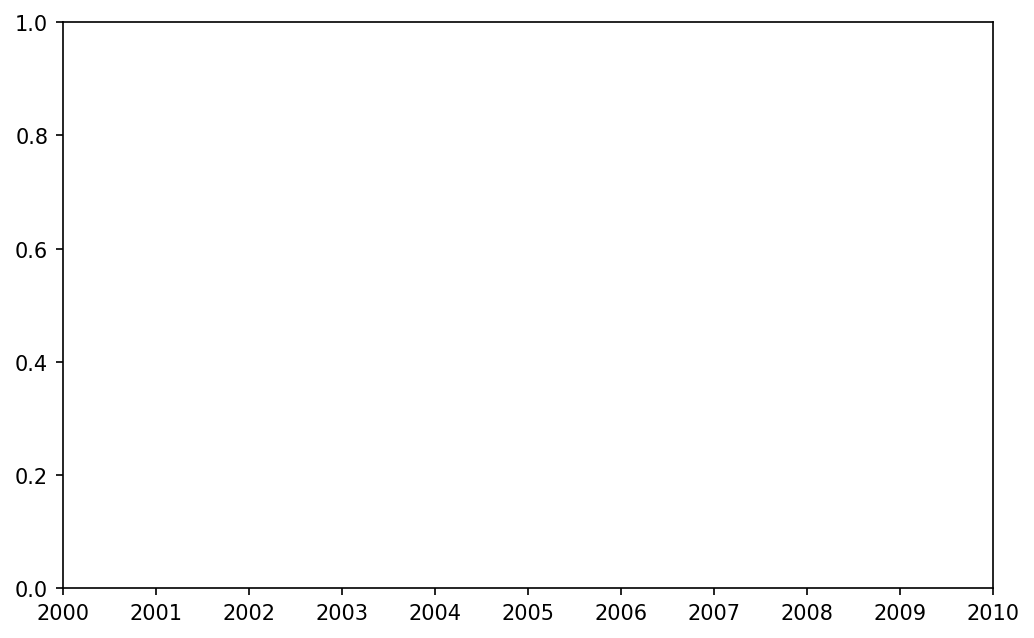

In [22]:
fig, ax = plt.subplots(dpi=150, figsize=(8,5))
pdf = gdf[gdf['start']>tz.make_aware(tz.datetime(2020,3,25,))].sort_values('finish').reset_index(drop=True)
pdf['cum_relevant'] = pdf['is_relevant'].cumsum()
print(pdf['cum_relevant'].tail(1))
pdf['seen'] = 1
pdf['cum_seen'] = pdf['seen'].cumsum().values
plt.plot_date(pdf['finish'],pdf['cum_relevant'],fmt="-",label="relevant documents seen")
plt.plot_date(pdf['finish'],pdf['cum_seen'],fmt="-", label="documents seen")
fig.autofmt_xdate(rotation=45)
ax.legend()
print(ax.get_xlim())

today = datetime.datetime(2020,4,29,23)

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

ax.axvline(today,color="grey",linestyle="--")
#ax.text(today+datetime.timedelta(days=1),max(pdf['cum_seen'])-100,"Today",bbox=props, ha="left")

ax.scatter(today+datetime.timedelta(8),1500,c="C1")
ax.axvline(today+datetime.timedelta(8),color="grey",linestyle="--")
ax.text(today+datetime.timedelta(days=9),1500,"Target",bbox=props, ha="left")

ax.axvline(today+datetime.timedelta(15),color="grey",linestyle="--")
ax.text(today+datetime.timedelta(days=16),max(pdf['cum_seen'])/2,"Preliminary\nresults",bbox=props, ha="left")

ax.set_xlim(xmax=today+datetime.timedelta(days=25))

ax.set_facecolor("white")
plt.savefig(f'../plots/progress/plan.pdf')
plt.show()

In [ ]:
Category.objects.filter(project=p).distinct('level').values('level')

In [ ]:
django.db.connection.close()
cat_dict = {}

for l in Category.objects.filter(project=p,level__gt=1).distinct('level').values_list('level',flat=True):
    cats = Category.objects.filter(project=p,level=l)
    parent = cats.first().parent_category
    cat_dict[f"{l} - {parent.name.replace('<hidden>','').strip()}"] = list(
        cats.exclude(name="not included in table").annotate(
            cname = Concat('level',V(' - '),'name',output_field=CharField())
        ).values_list('cname',flat = True)
    )
    
cat_dict.values()

In [ ]:
django.db.connection.close()

cats = Category.objects.filter(project=p)
ldf = pd.DataFrame.from_dict(list(Doc.objects.filter(pk__in=dos.values_list('doc_id')).filter(
    category__in=cats
).values('id','category__name','category__level')))
ldf['v'] = 1
ldf['category__name'] = ldf['category__level'].astype('str') + " - " +  ldf['category__name'] 
ldf = ldf.drop('category__level',axis=1).drop_duplicates()

cat_map = ldf.pivot(index='id',columns="category__name", values="v")
cat_map['doc_id'] = cat_map.index
cat_map = cat_map.reset_index(drop=True)

df = pd.merge(gdf, cat_map, how="left").fillna(0)

for c in cats:
    if f"{c.level} - {c.name}" not in df.columns:
        df[f"{c.level} - {c.name}"] = 0

print(df.shape)
df.head()

In [ ]:
ldf

In [ ]:
pdf.head()

In [ ]:
fig, ax = plt.subplots()
ticks = []
for i,c in enumerate(cat_dict['12 - AR5 Category']):
    l,cname = c.split(' - ')
    cat = Category.objects.get(project=p,level=l,name=cname)
    cdocs = Doc.objects.filter(category=cat).values_list('pk', flat=True)
    ecdocs = Doc.objects.filter(category__equivalents=cat).values_list('pk',flat=True)
    all_docs = set(cdocs) | set(ecdocs)
    ax.barh(i,len(all_docs),color="none",edgecolor="grey",linewidth=1)
    ax.barh(i,len(cdocs),color="grey",alpha=0.1,edgecolor="grey",linewidth=1)
    ticks.append(cname)

ax.set_yticks(range(len(ticks)))
ax.set_yticklabels(ticks)


In [ ]:
for cat, cols in cat_dict.items():
    fig, ax = plt.subplots(dpi=150) 
    cols = cat_dict[cat]
    pdf = df[cols].cumsum()
    pdf = pdf[pdf.sum(axis=1)>1]
    pdf.plot(ax=ax)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_title(cat)
    plt.savefig(f'../plots/progress/{cat}.pdf'.replace(' ','_'), bbox_inches="tight")
    plt.show()
cols

In [ ]:
print("\n".join(sorted(cat_dict["AR5 Symbol"])))

In [ ]:
def cat_heatmap(df,cat_dict, c1, c2, ax, labels = True):
    mdf = pd.DataFrame()
    tdf = df
    for cc1 in sorted(cat_dict[c1]):
        for cc2 in sorted(cat_dict[c2]):
            tdf['cs'] = df[cc1] + df[cc2]
            mdf.loc[cc2,cc1] = df.query('cs==2').shape[0]
    sums = mdf.sum(axis=1)
    
    for c in mdf.columns:
        mdf[c] = mdf[c] / sums
    mdf = mdf.fillna(0)
    sns.heatmap(
        mdf, cmap="Blues",linewidths=.5, 
        cbar_kws={'label': 'row proportions'},ax=ax,
        vmin=0.01
    )
    if labels:
        for i, (rin,r) in enumerate(mdf.iterrows()):
            for j, v in enumerate(r.values):
                if v==0:
                    continue
                if v > 0.5:
                    c = "white"
                else:
                    c = "black"
                ax.text(j+0.5,i+0.5,f"{v:.0%}",ha="center",va="center",color=c)
    ax.set_title(f"{c1}-{c2}")
    
fig, ax = plt.subplots()
cat_heatmap(df, cat_dict, "AR5 Category", "AR6 Category",ax)
plt.savefig(f'../plots/progress/AR5_Category__AR6_Category.pdf'.replace(' ','_'), bbox_inches="tight")

In [ ]:
fig, ax = plt.subplots()
cat_heatmap(df, cat_dict, "AR5 Category", "AR5 Symbol", ax)
plt.savefig(f'../plots/progress/AR5_Category__AR5_Symbol.pdf'.replace(' ','_'), bbox_inches="tight")

In [ ]:
fig, ax = plt.subplots()
cat_heatmap(df, cat_dict, "AR6 Category", "AR5 Symbol", ax)
plt.savefig(f'../plots/progress/AR6_Category__AR5_Symbol.pdf'.replace(' ','_'), bbox_inches="tight")

In [ ]:
cat_dict["AR6 Category"]

In [ ]:
fig, axs = plt.subplots(1,4,figsize=(20,12), sharey=True)
for i, c1 in enumerate(["AR6 Category","AR5 Category","AR5 Symbol","Attribution"]):
    ax = axs[i]
    cat_heatmap(df, cat_dict, c1, "AR6 Impact", ax)
    
fig.tight_layout()
plt.savefig(f'../plots/progress/AR6_Impact_overlap.pdf'.replace(' ','_'), bbox_inches="tight")

In [ ]:
fig, ax = plt.subplots(figsize=(5,8))
cat_heatmap(df, cat_dict, "AR6 Category", "AR6 Impact", ax)
plt.savefig(f'../plots/progress/AR6_Category__AR6_Impact.pdf'.replace(' ','_'), bbox_inches="tight")

In [ ]:
fig, ax = plt.subplots(figsize=(5,8))
cat_heatmap(df, cat_dict, "AR5 Category", "AR6 Impact", ax)
plt.savefig(f'../plots/progress/AR5_Category__AR6_Impact.pdf'.replace(' ','_'), bbox_inches="tight")

In [ ]:
fig, ax = plt.subplots(figsize=(5,8))
cat_heatmap(df, cat_dict, "AR5 Symbol", "AR6 Impact", ax)
plt.savefig(f'../plots/progress/AR5_Symbol__AR6_Impact.pdf'.replace(' ','_'), bbox_inches="tight")

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
cat_heatmap(df, cat_dict, "AR5 Symbol", "Region", ax)
plt.savefig(f'../plots/progress/AR5_Symbol__Region.pdf'.replace(' ','_'), bbox_inches="tight")

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
cat_heatmap(df, cat_dict, "AR5 Category", "Region", ax)
plt.savefig(f'../plots/progress/AR5_Category__Region.pdf'.replace(' ','_'), bbox_inches="tight")

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
cat_heatmap(df, cat_dict, "AR6 Category", "Region", ax)
plt.savefig(f'../plots/progress/AR6_Category__Region.pdf'.replace(' ','_'), bbox_inches="tight")

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
cat_heatmap(df, cat_dict, "Attribution", "Region", ax)
plt.savefig(f'../plots/progress/Attribution__Region.pdf'.replace(' ','_'), bbox_inches="tight")

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
cat_heatmap(df, cat_dict, "Attribution", "AR5 Symbol", ax)
plt.savefig(f'../plots/progress/Attribution__AR5 Symbol.pdf'.replace(' ','_'), bbox_inches="tight")

In [ ]:
fig, ax = plt.subplots(figsize=(5,8))
cat_heatmap(df, cat_dict, "Region", "AR6 Impact", ax)
plt.savefig(f'../plots/progress/AR6_Impact__Region.pdf'.replace(' ','_'), bbox_inches="tight")

In [ ]:
fig, ax = plt.subplots(figsize=(5,8))
cat_heatmap(df, cat_dict, "Region", "AR6 Impact", ax)
plt.savefig(f'../plots/progress/AR6_Impact__Region.pdf'.replace(' ','_'), bbox_inches="tight")